In [520]:
# sys tools
import os
import pathlib
from PIL import Image

# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# ResNet50 model
from tensorflow.keras.applications.resnet50 import (preprocess_input,
                                                    decode_predictions,
                                                    ResNet50)

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout,
                                     Conv2D,
                                     Activation, 
                                     MaxPooling2D)

# generic model object
from tensorflow.keras.models import Model, Sequential

# optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1,l2,l1_l2

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

# for plotting
import numpy as np
import matplotlib.pyplot as plt

## Plot function

In [490]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Loader params

In [491]:
batch_size = 32
img_height = 150
img_width = 150

In [492]:
train_data_dir = pathlib.Path("../DATA/PNG_RGB/merged")
test_data_dir = pathlib.Path("../DATA/PNG_RGB/test")

# Loading

In [493]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  color_mode="rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  color_mode="rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 948 files belonging to 2 classes.
Using 759 files for training.
Found 948 files belonging to 2 classes.
Using 189 files for validation.


## Test data

In [494]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    color_mode="rgb",
    shuffle=False,
    image_size=(img_height, img_width))

Found 102 files belonging to 2 classes.


## Augment

In [495]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Check class names

In [496]:
class_names = train_ds.class_names
print(class_names)

['MND', 'NEG']


# Inspect random images

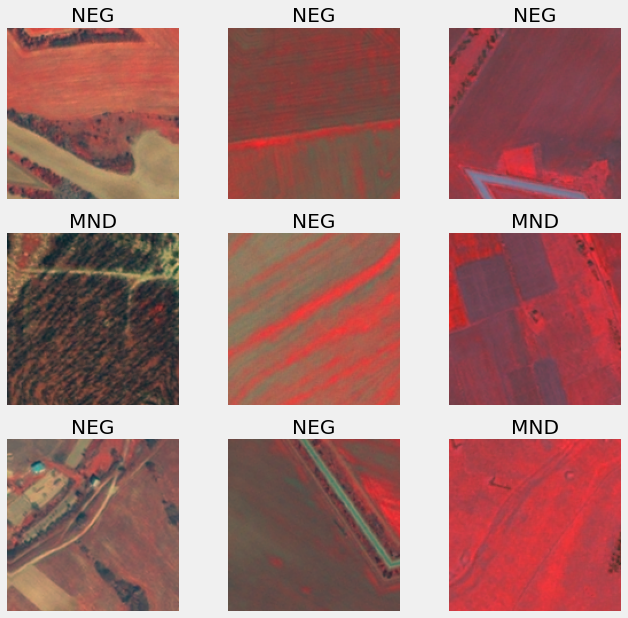

In [497]:
plt.figure(figsize=(10, 10))
for images, labels in aug_ds.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Transfer learning - VGG16

In [635]:
tf.keras.backend.clear_session()

In [636]:
# load model without classifier layers
model = ResNet50(include_top=False, 
              pooling='avg',
              input_shape=(150, 150, 3))

In [637]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [638]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints", 
                                                mode='min', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True)
callbacks_list = [checkpoint]

In [639]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, 
               activation='relu', 
               kernel_regularizer=l2(0.0001), 
               bias_regularizer=l2(0.0001))(flat1)
drop1 = Dropout(0.2)(class1)
output = Dense(1, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

In [630]:
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy',
                       tf.keras.metrics.AUC()])

In [631]:
H = model.fit(aug_ds,
              validation_data=val_ds, 
              batch_size=32,
              epochs=10,
              verbose=1,
              callbacks=callbacks_list)

Epoch 1/10
24/24 [==============================] - 43s 2s/step - loss: 0.6913 - binary_accuracy: 0.6061 - auc: 0.6539 - val_loss: 0.5886 - val_binary_accuracy: 0.7143 - val_auc: 0.8093

Epoch 00001: val_loss improved from -inf to 0.58856, saving model to checkpoints


/Users/au564346/Desktop/IKmoundAnalysis/env/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints/assets
Epoch 2/10
24/24 [==============================] - 38s 2s/step - loss: 0.4996 - binary_accuracy: 0.7905 - auc: 0.8601 - val_loss: 0.5046 - val_binary_accuracy: 0.7831 - val_auc: 0.8477

Epoch 00002: val_loss did not improve from 0.58856
Epoch 3/10
24/24 [==============================] - 38s 2s/step - loss: 0.4616 - binary_accuracy: 0.7905 - auc: 0.8829 - val_loss: 0.4759 - val_binary_accuracy: 0.7725 - val_auc: 0.8734

Epoch 00003: val_loss did not improve from 0.58856
Epoch 4/10
24/24 [==============================] - 38s 2s/step - loss: 0.4177 - binary_accuracy: 0.8235 - auc: 0.9091 - val_loss: 0.4446 - val_binary_accuracy: 0.8042 - val_auc: 0.8899

Epoch 00004: val_loss did not improve from 0.58856
Epoch 5/10
24/24 [==============================] - 39s 2s/step - loss: 0.3854 - binary_accuracy: 0.8472 - auc: 0.9270 - val_loss: 0.4359 - val_binary_accuracy: 0.8042 - val_auc: 0.8988

Epoch 00005: val_loss did not improve from 0.

In [646]:
H.accuracy

AttributeError: 'History' object has no attribute 'accuracy'

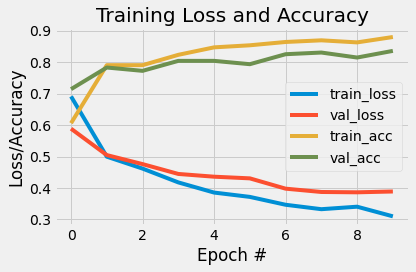

In [633]:
plot_history(H, 10)

## Predict unseent

In [578]:
predicted_categories = (model.predict(test_ds) > 0.5).astype("int32")

In [579]:
true_categories = tf.concat([y for x, y in test_ds], axis = 0).numpy()
print(classification_report(true_categories, 
                            predicted_categories,
                            target_names=class_names))

              precision    recall  f1-score   support

         MND       0.88      0.86      0.87        51
         NEG       0.87      0.88      0.87        51

    accuracy                           0.87       102
   macro avg       0.87      0.87      0.87       102
weighted avg       0.87      0.87      0.87       102



## Predict test image

In [600]:
image = load_img('../CNN_classifiers/2_CNN_mounds_not-mounds/SimpleNet/1_train_from_scratch/test.jpg', 
                 target_size=(150, 150))
image = img_to_array(image)

In [601]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [602]:
# prepare the image for the VGG model
image = preprocess_input(image)

In [603]:
# predict the probability across all output classes
y_pred = model.predict(image)

In [604]:
y_pred

array([[0.5793334]], dtype=float32)